# Tutorial: SimGromacs wrapper
In this tutorial we will go through an example of how to use the wrapper for the [GROMACS](https://www.gromacs.org/) simulation engine.
You can find the wrapper [here](https://gitlab.cc-asp.fraunhofer.de/simphony/wrappers/simgromacs).

## Background
[GROMACS](https://www.gromacs.org/) is a simulation engine for performing molecular dynamics simulations by approximating solution to the Newtonian equations of motion for systems with a larger number of particles.

The GROMACS wrapper was first introduced to SimPhoNy during the [FORCE](https://www.the-force-project.eu/) project. Later it was modified for the Apache project with more functionality and generalization.

## Let’s get hands on

### Installation
We provide two ways for installing the wrapper: _locally_ or using a _Docker
container_.

#### Local installation
The following requires you to have OSP core installed, as well as a recent
version of the Gromacs simulation software (we have tested against [Gromacs
2020](https://manual.gromacs.org/2020/release-notes/index.html) and [Gromacs
2019](https://manual.gromacs.org/2019.4/release-notes/2019/2019.4.html)-- an
installation script, `install_engine.sh`, is provided).

Install the ontology via `pico install simgromacs-ontology.yml` and the actual SimGromacs wrapper by running `pip install .`.

#### Docker installation
The container installation, on the other hand, takes care of all of the
requirements, but can take up to an hour to build for the first time.

**Note**: To avoid unexpected errors and confusion, please make sure to use
the provided installation script, rather than directly building using the
`Dockerfile`, as we use a multi-stage build.

Run `chmod +x && ./docker_install.sh` to create a container using our multi-stage build.

### Setting up the simulation
To run a Gromacs simulation through the SimGromacs wrapper, you need to create a Python file. In the file you need to specify the various simulation parameters in terms of CUDS. Mainly two kinds of parameters are needed for simulation.

   1. Molecular concentrations and structure such as surfactant, solvent, ions, atoms and their bonds. Gromacs needs this information as .gro, .top, .mdp, and .itp files. The user can provide this information by either creating the CUDS representation of these files (FORCE project) or by providing the simulation path to the wrapper session where all these files are stored in the same directory(APACHE project). 


   2. Simulation workflow and their corresponding simulation parameters such as integration time, time step, type of integrator, pressure, temperature, boundary conditions, coulombic potential, etc. The current wrapper supports the user to run workflow in any order and any number of times. Currently, following simulation workflows have been supported by the wrapper:
    - Energy Minimization
    - Dimensions optimization (also known as equalisation or priming in MD world)
    - Simulation
    - Post processing (Energy computation, msd computation, pst computation)

As a final step you need to communicate to the wrapper, that the simulation should be started via the SimgromacsSession::run command.

Once the simulation has completed its run, you can query the resultant atom, positions and velocities through the CUDS objects.
Additionally, all of the simulation files including the input files generated by the SimGromacs wrapper using your input parameters, the indermediate files and the output files are stored inside the simulation directory. Inorder to delete the files in this directory you can communicate that through the constructor of the SimgromacsSession by setting the delete_simulation_files to True.

### Simple example
This is an adaptation of simgromacs/examples/apache.py from Apache use case.
As usual, we start importing the necessary components:


In [1]:
from osp.core.namespaces import simgromacs, emmo, cuba
from osp.wrappers.simgromacs import SimgromacsSession
from osp.core.utils import pretty_print

As a first step for Apche use case we need to set the simulation path parameter which indicates the input files stored location. The output will also be saved in the same directory once the simulation is complete. 

In [2]:
# path where the gromacs inputs files are stored
SIMULATION_PATH = "/root/symphony/Gromacs_files_2"

We create the wrapper instance.
All wrappers are created by defining their own [session class](../detailed_design.md#session).

In [3]:
# Create container for the wrapper and run the simulation
with SimgromacsSession(
        delete_simulation_files=False,
        simulation_path=SIMULATION_PATH) as session:
    gromacs_wrapper = cuba.Wrapper(session=session)

/root/symphony/Gromacs_files_2/simulation-777bb7be-5396-43fd-83e4-ff881d5a33ee


Instantiate a simulation CUDS object which stores all the simulation parameters as explained above. 

In [4]:
    # Create simulation entity
    sim = simgromacs.MolecularDynamicsSimulation()

Create the first workflow step of the simulation with necessary parameters. In the below example the __first step__ is __NVT equilibrium__ which is a optimization step. Create a CUDS object of __NVTCalculation__ and then add the necessry parameters for this simulation step as additional CUDS objects. Below code contains an example for creating integration time and simulation temperature parameters. Finally add the NVT object to sim object created above with relation type __hasTemporalFirst__.

In [5]:
    # Configure the solver parameters for the final run of the simulation (NVT)
    nvt = simgromacs.NVTCalculation()

    thermodynamic_temp = emmo.ThermodynamicTemperature()
    temperature = emmo.Real(hasNumericalData=500)
    thermodynamic_temp.add(temperature, rel=emmo.hasQuantityValue)

    integration_time = simgromacs.IntegrationTime()
    num_steps = emmo.Real(hasNumericalData=5000)
    integration_time.add(num_steps, rel=emmo.hasQuantityValue)

    nvt.add(integration_time, thermodynamic_temp,
            rel=simgromacs.hasOptimizationInput)
    sim.add(nvt, rel=emmo.hasTemporalFirst)

<simgromacs.NVTCalculation: 47b0686d-a4d2-4320-87a9-81d50d10920f,  CoreSession: @0x7f5587ffc278>

To add the __second step__ of the workflow (__NPT equilibrium__ in the below case) create the CUDS object similar to above and add the object to first simulation object(NVT) with a relation __hasTemporalNext__. Here, hasTemporalNext indicates the type of workflow following next. If nothing is specified then it indicates the end of smulation workflow.
In the below use case NPT represents actual simulation step.

In [6]:
    # Configure the solver parameters for the
    # dimensions optimization step (NPT)
    npt = simgromacs.NPTCalculation()

    thermodynamic_temp = emmo.ThermodynamicTemperature()
    temperature = emmo.Real(hasNumericalData=500)
    thermodynamic_temp.add(temperature, rel=emmo.hasQuantityValue)

    integration_time = simgromacs.IntegrationTime()
    num_steps = emmo.Real(hasNumericalData=5000)
    integration_time.add(num_steps, rel=emmo.hasQuantityValue)

    npt.add(integration_time, thermodynamic_temp,
            rel=simgromacs.hasSimulationInput)

    nvt.add(npt, rel=emmo.hasTemporalNext)

<simgromacs.NPTCalculation: a6d1904c-ce92-4fca-9320-6ee42dd56cf0,  CoreSession: @0x7f5587ffc278>

The __third step__ of the work flow is __Total energy computation__ which is a post processing step. Usually post processing steps are performed at the end after simulation step(second step in this use case). Energy computation requires list of options where each option indicates the type of analysis to perform. The user can either provide the options as numbers if they know mapping or as string values.

In [7]:
    # Configuration for Post Processing
    energy_computation = simgromacs.EnergyComputation()
    options = emmo.Symbol(hasSymbolData="14, 16, 24")

    # options = emmo.Symbol(hasSymbolData="Total-Energy, Temperature, Density")
    energy_computation.add(options, rel=simgromacs.hasInput)
    npt.add(energy_computation, rel=emmo.hasTemporalNext)

<simgromacs.EnergyComputation: a204f9fd-c024-4de9-8bd0-7d25338c7512,  CoreSession: @0x7f5587ffc278>

__Fourth__ and __Fifth__ steps are again post processing steps for __mean square distance__ and __polymer static property__ calculation. Similar to above case we need list of options here as well. It is important to add each step with __hastemporalNext__ relation to the previous one.

In [8]:
    msd = simgromacs.MeanSquareDistanceComputation()
    options = emmo.Symbol(hasSymbolData="23, 10, 9, 8")
    msd.add(options, rel=simgromacs.hasInput)
    energy_computation.add(msd, rel=emmo.hasTemporalNext)

    pst = simgromacs.PolymerStaticPropertyComputation()
    options = emmo.Symbol(hasSymbolData="23")
    pst.add(options, rel=simgromacs.hasInput)
    msd.add(pst, rel=emmo.hasTemporalNext)

<simgromacs.PolymerStaticPropertyComputation: 0b1d88d3-8f70-4c59-bf43-d44bbe4c7683,  CoreSession: @0x7f5587ffc278>

Simgromacs wrapper expects all the files(.gro, .top, .mdp files) in the same directory. The wrapper expects only one .gro and .top files(filename can be anything). However, there can be multiple .mdp files each one for individual workflow. In the above case it has to be nvt.mdp and npt.mdp(file names are important here). 

For Apache use case the files are provided in a different directory structure(Naming convention is important). The wrapper expects the user to provide files in following format.
>Root directory/<br>
>|----Polymer only/<br>
>|&emsp; &emsp;.gro, .top files<br>
>|----Polymer+VOC/<br>
>|  &emsp; &emsp; 1000ppm/<br>
>|   &emsp;&emsp; &emsp;&emsp;   .gro, .top, .ndx files<br>
>|    &emsp;&emsp;2000ppm/<br>
>|     &emsp;&emsp; &emsp;&emsp;  .gro, .top, .ndx files<br>
>|----Polymer+Water/<br>
>| nvt.mdp<br>
>| npt.mdp<br>


In order to read the files from the above directory structure the user has to provide the details as inputs represented as  CUDS object to simulation object. For apache we need inputs like type of pollutant, pollutant quantity and copolymer used.

In [9]:
    # Configuration for selecting files from cooling step
    coarse_grain_representation = simgromacs.CoarseGrainRepresentation()
    # add pollutant
    voc = simgromacs.VOC()
    voc.add(coarse_grain_representation, rel=emmo.hasSign)

    # add copolymer input
    copolymer = simgromacs.PMMAconBA()
    copolymer.add(coarse_grain_representation, rel=emmo.hasSign)

    # add pollutant level
    mass_concentration = emmo.MassConcentration()
    pollutant_level = emmo.Real(hasNumericalData=1000)
    mass_concentration.add(pollutant_level, rel=emmo.hasQuantityValue)
    mass_concentration.add(coarse_grain_representation,
                           rel=emmo.hasSpatialPart)

    sim.add(coarse_grain_representation, rel=simgromacs.hasInput)

    sim = gromacs_wrapper.add(sim, rel=emmo.hasPart)

To run the simulation, we call the run() method of the session. The run method sends the information to the engine, and informs it to run the simulation based on the inputs provided as CUDS structure.

_gromacs_wrapper.session.run()_

Now lets run whole code together. 

/root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c
/root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c
[<simgromacs.VOC: 79f07eee-8d79-4adf-91d3-f8f2add267b1,  SimgromacsSession: @0x7f55842d7588>, <simgromacs.PMMAconBA: d1d905fd-831a-4e0d-b632-bddcfc13cb46,  SimgromacsSession: @0x7f55842d7588>]
(pollutant, Pollutant Quantity, Copolymer type) 
VOC 1000 nba
Performing Optimization step.....
{'nsteps': '5000', 'ref_t': '500', 'gen_temp': '500'}
gmx grompp --maxwarn 5 -f /root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c/grompp-opt.mdp -p /root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c/topol.top -c /root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c/conf.gro -o /root/symphony/Gromacs_files_2/simulation-a207a1af-5778-4ad2-be3b-e70a5702f71c/topol.tpr
b'turning H bonds into constraints...\nturning H bonds into constraints...\nturning H bonds into constra

b''
b'                      :-) GROMACS - gmx mdrun, 2019.4 (-:\n\n                            GROMACS is written by:\n     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen\n    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    \n Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     \n  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  \n  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis\n    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    \n  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   \n    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   \n    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  \n   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen \n Christian Wennberg    Maarten Wolf   \n                           and the project leaders:\n    

                      :-) GROMACS - gmx energy, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Be

Performing Post processing step.....
emmo.Symbol: 5e2e8a9b-b8e8-4745-8505-59127b8e250c


                       :-) GROMACS - gmx msd, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk

b"Selected 23: 'Copolymer'\nFitting from 0 to 8 ps\n\nD[ Copolymer] 0.6749 (+/- 0.0000) 1e-5 cm^2/s"


                       :-) GROMACS - gmx msd, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk

b"Selected 10: 'ACE'\nFitting from 0 to 8 ps\n\nD[       ACE] 0.7689 (+/- 0.0000) 1e-5 cm^2/s"


                       :-) GROMACS - gmx msd, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk

b"Selected 9: 'COO'\nFitting from 0 to 8 ps\n\nD[       COO] 0.9611 (+/- 0.0000) 1e-5 cm^2/s"


                       :-) GROMACS - gmx msd, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk

b"Selected 8: 'CHO'\nFitting from 0 to 8 ps\n\nD[       CHO] 1.6269 (+/- 0.0000) 1e-5 cm^2/s"
Performing Post processing step.....
emmo.Symbol: d9c3426f-deb7-4104-82c4-3e93d3c50526


                     :-) GROMACS - gmx polystat, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, B

b"Selected 23: 'Copolymer'\n\nAverage end to end distance: 2.202 (nm)\n\nAverage radius of gyration:  0.924 (nm)"


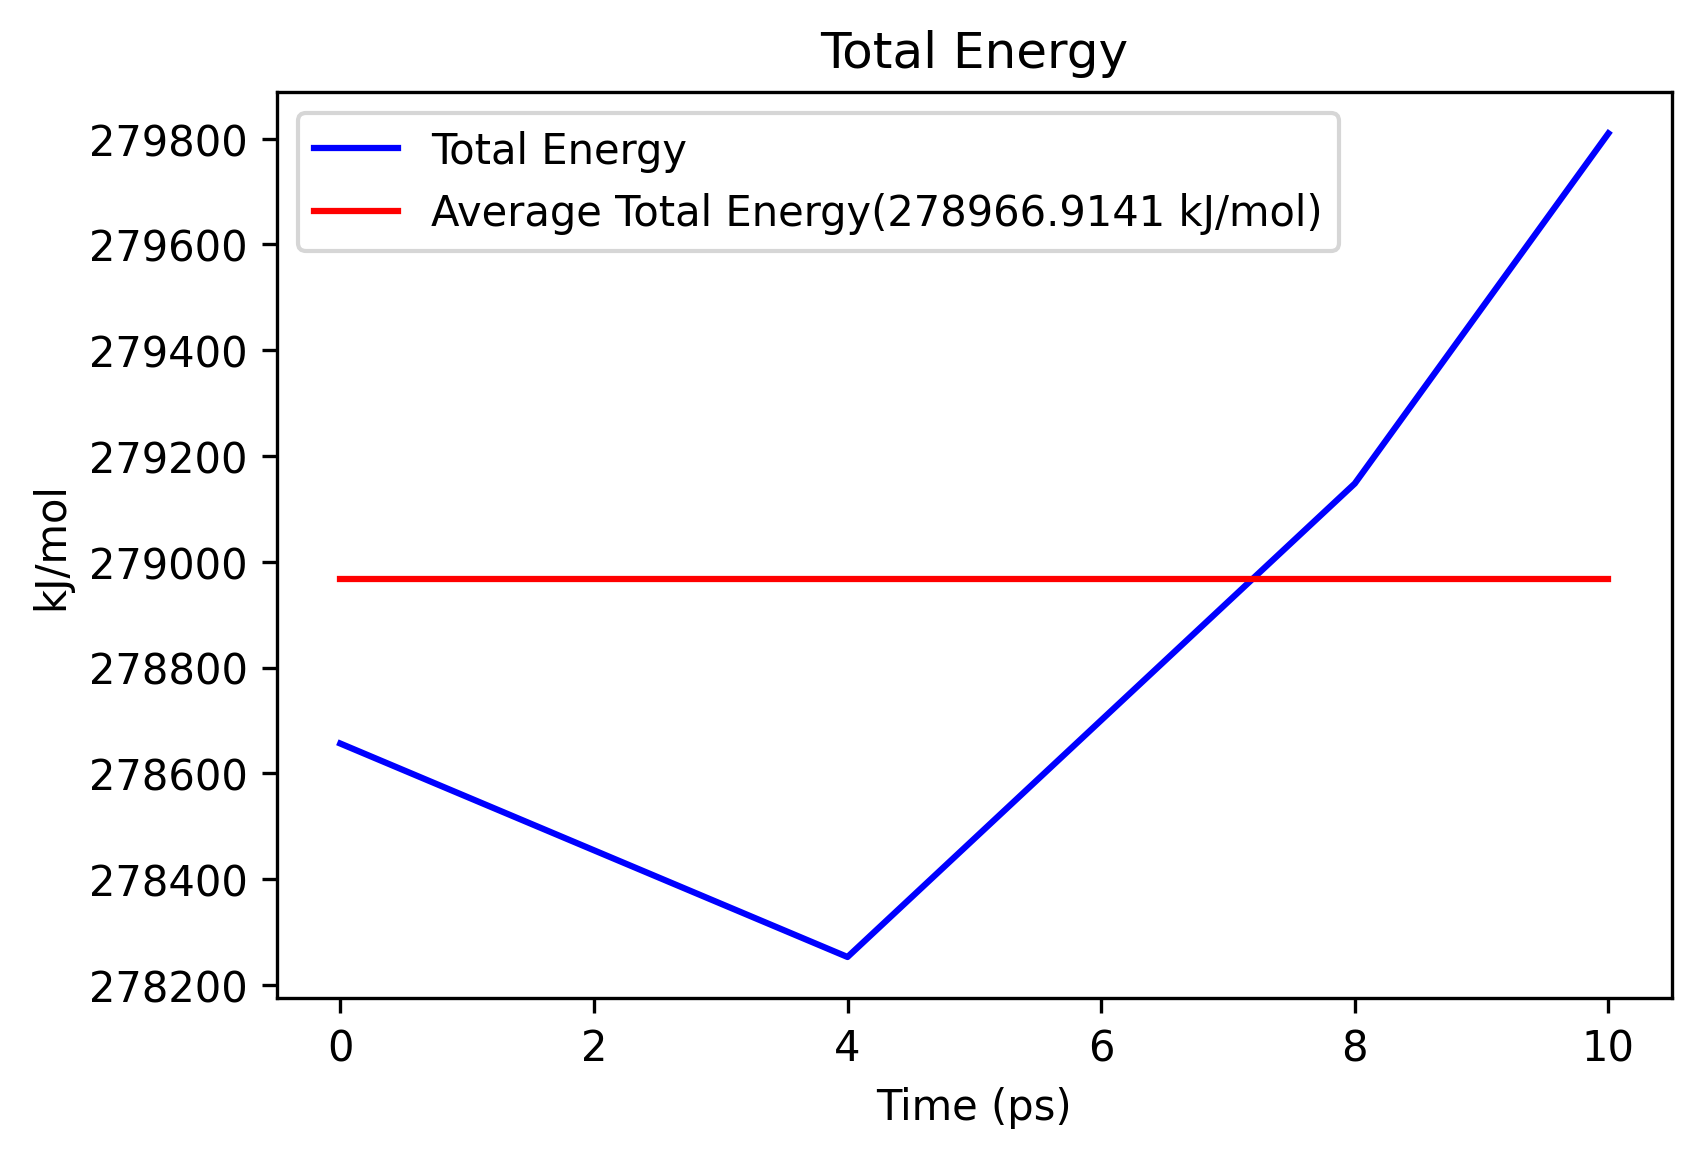

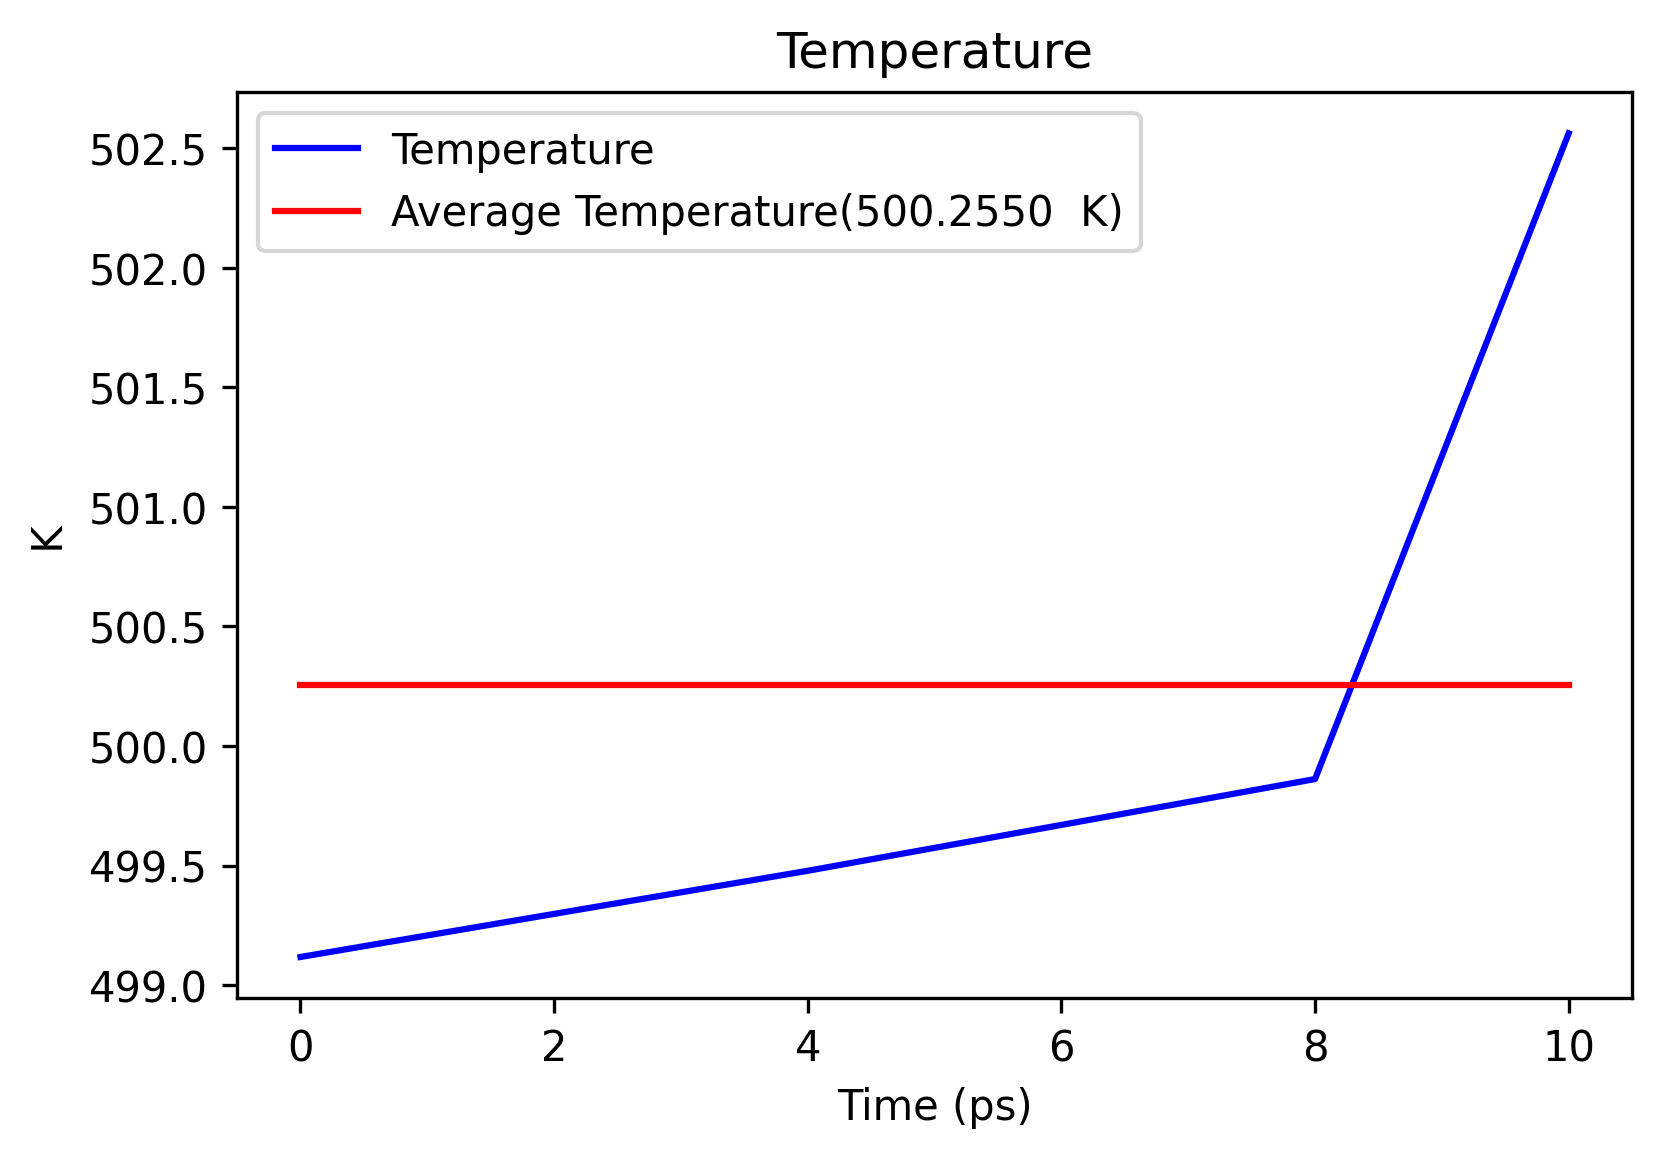

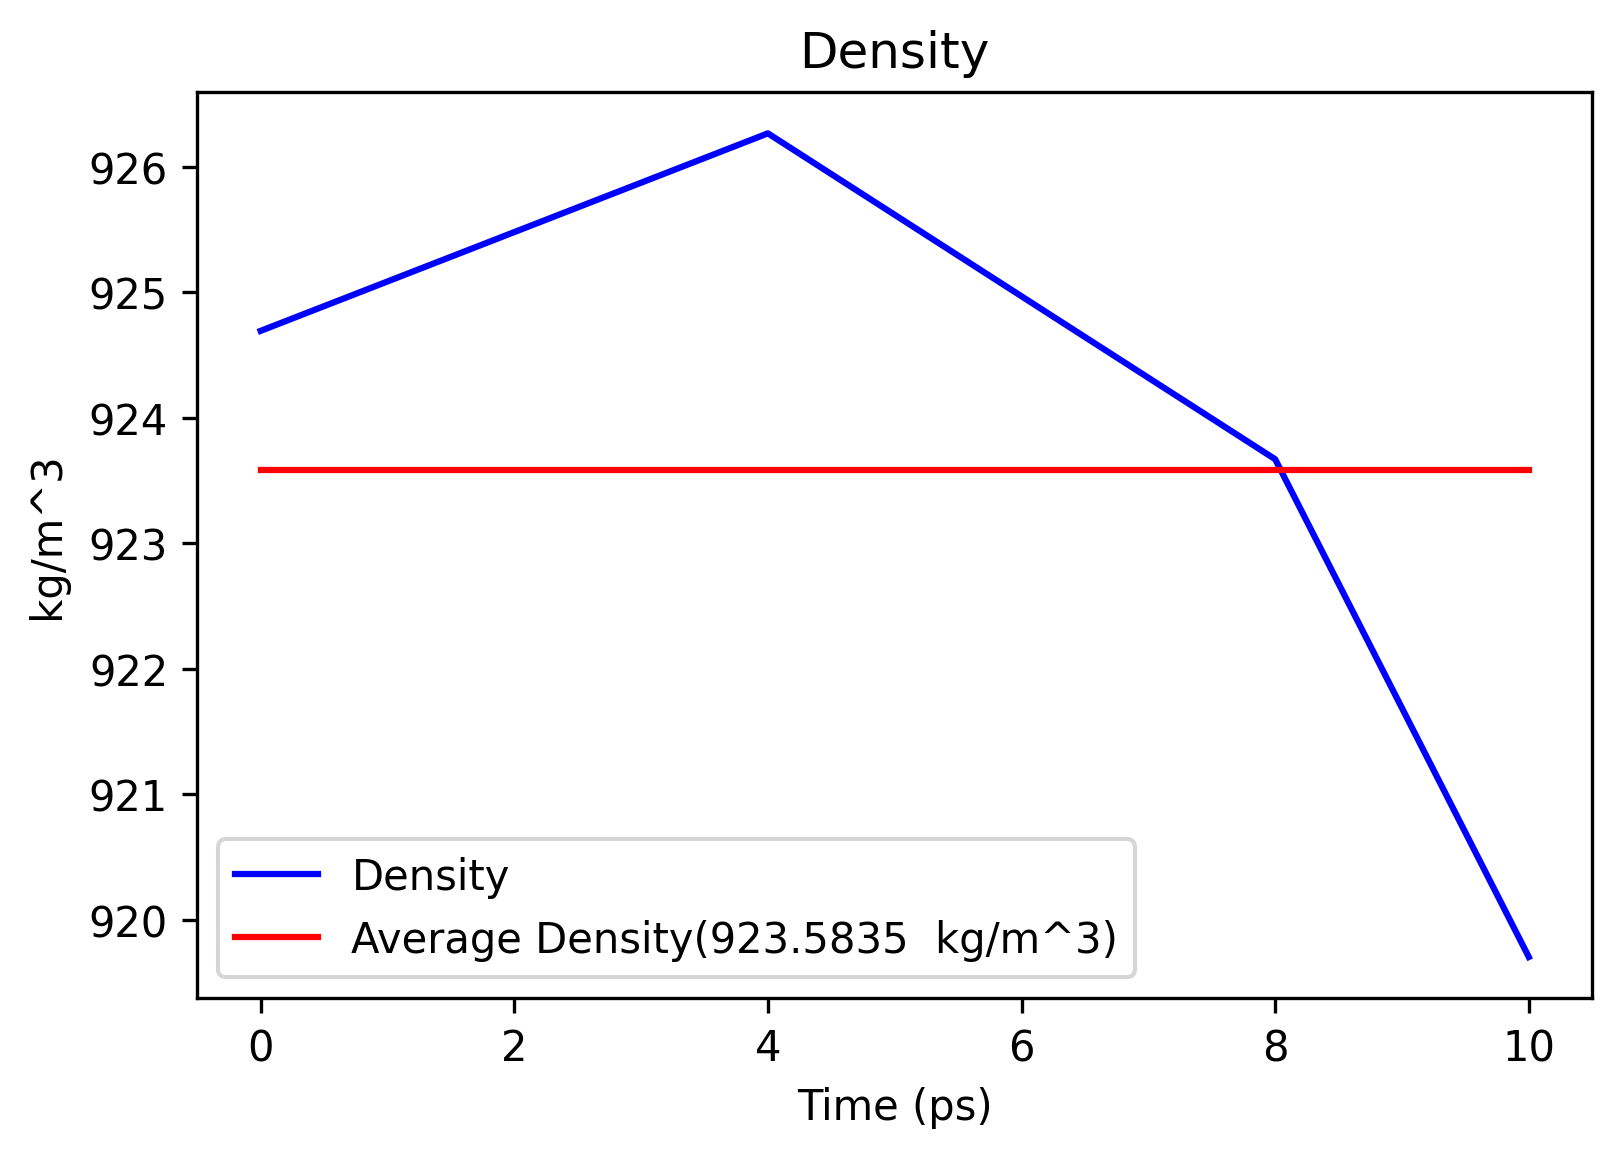

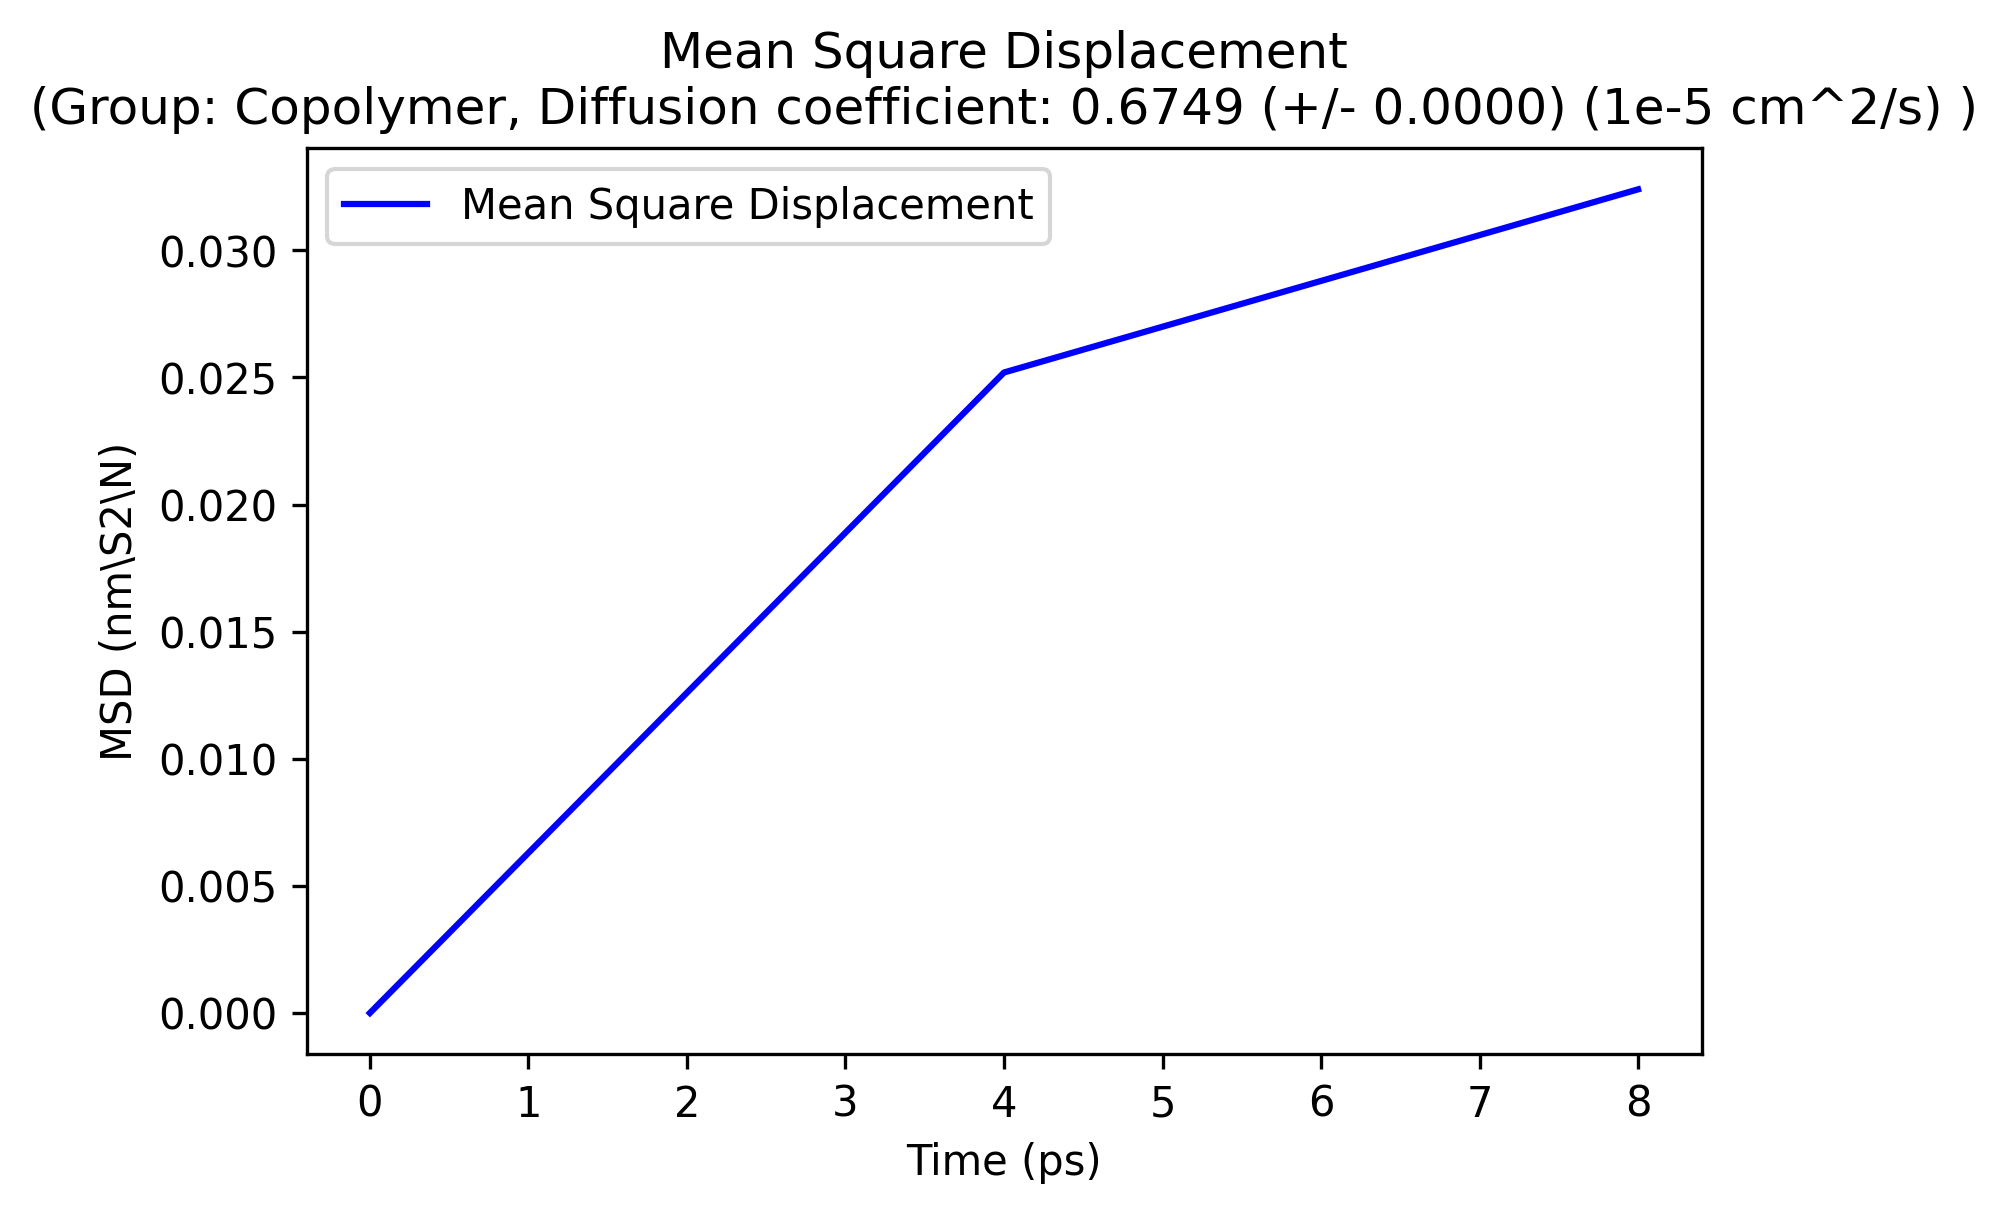

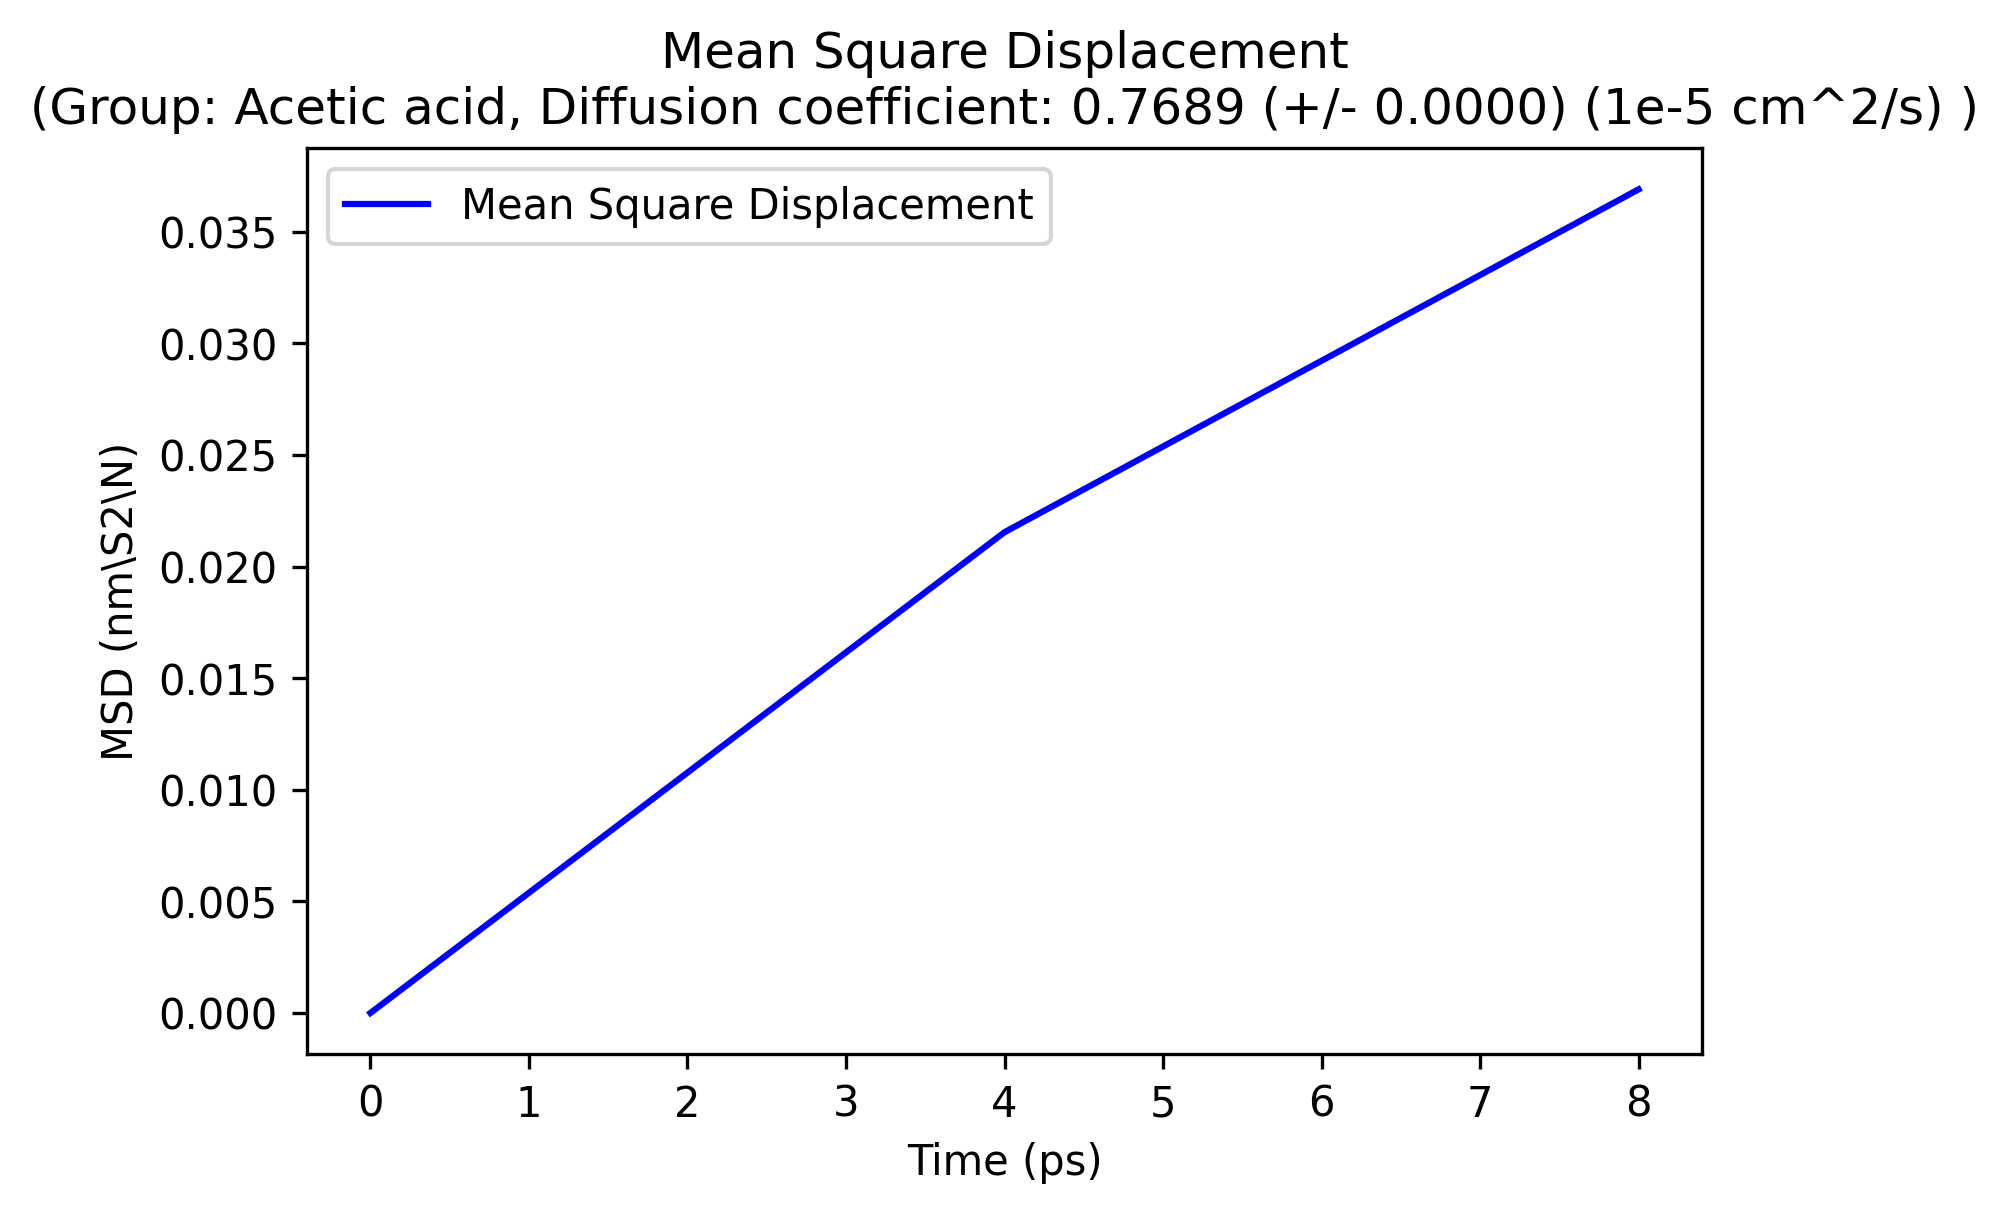

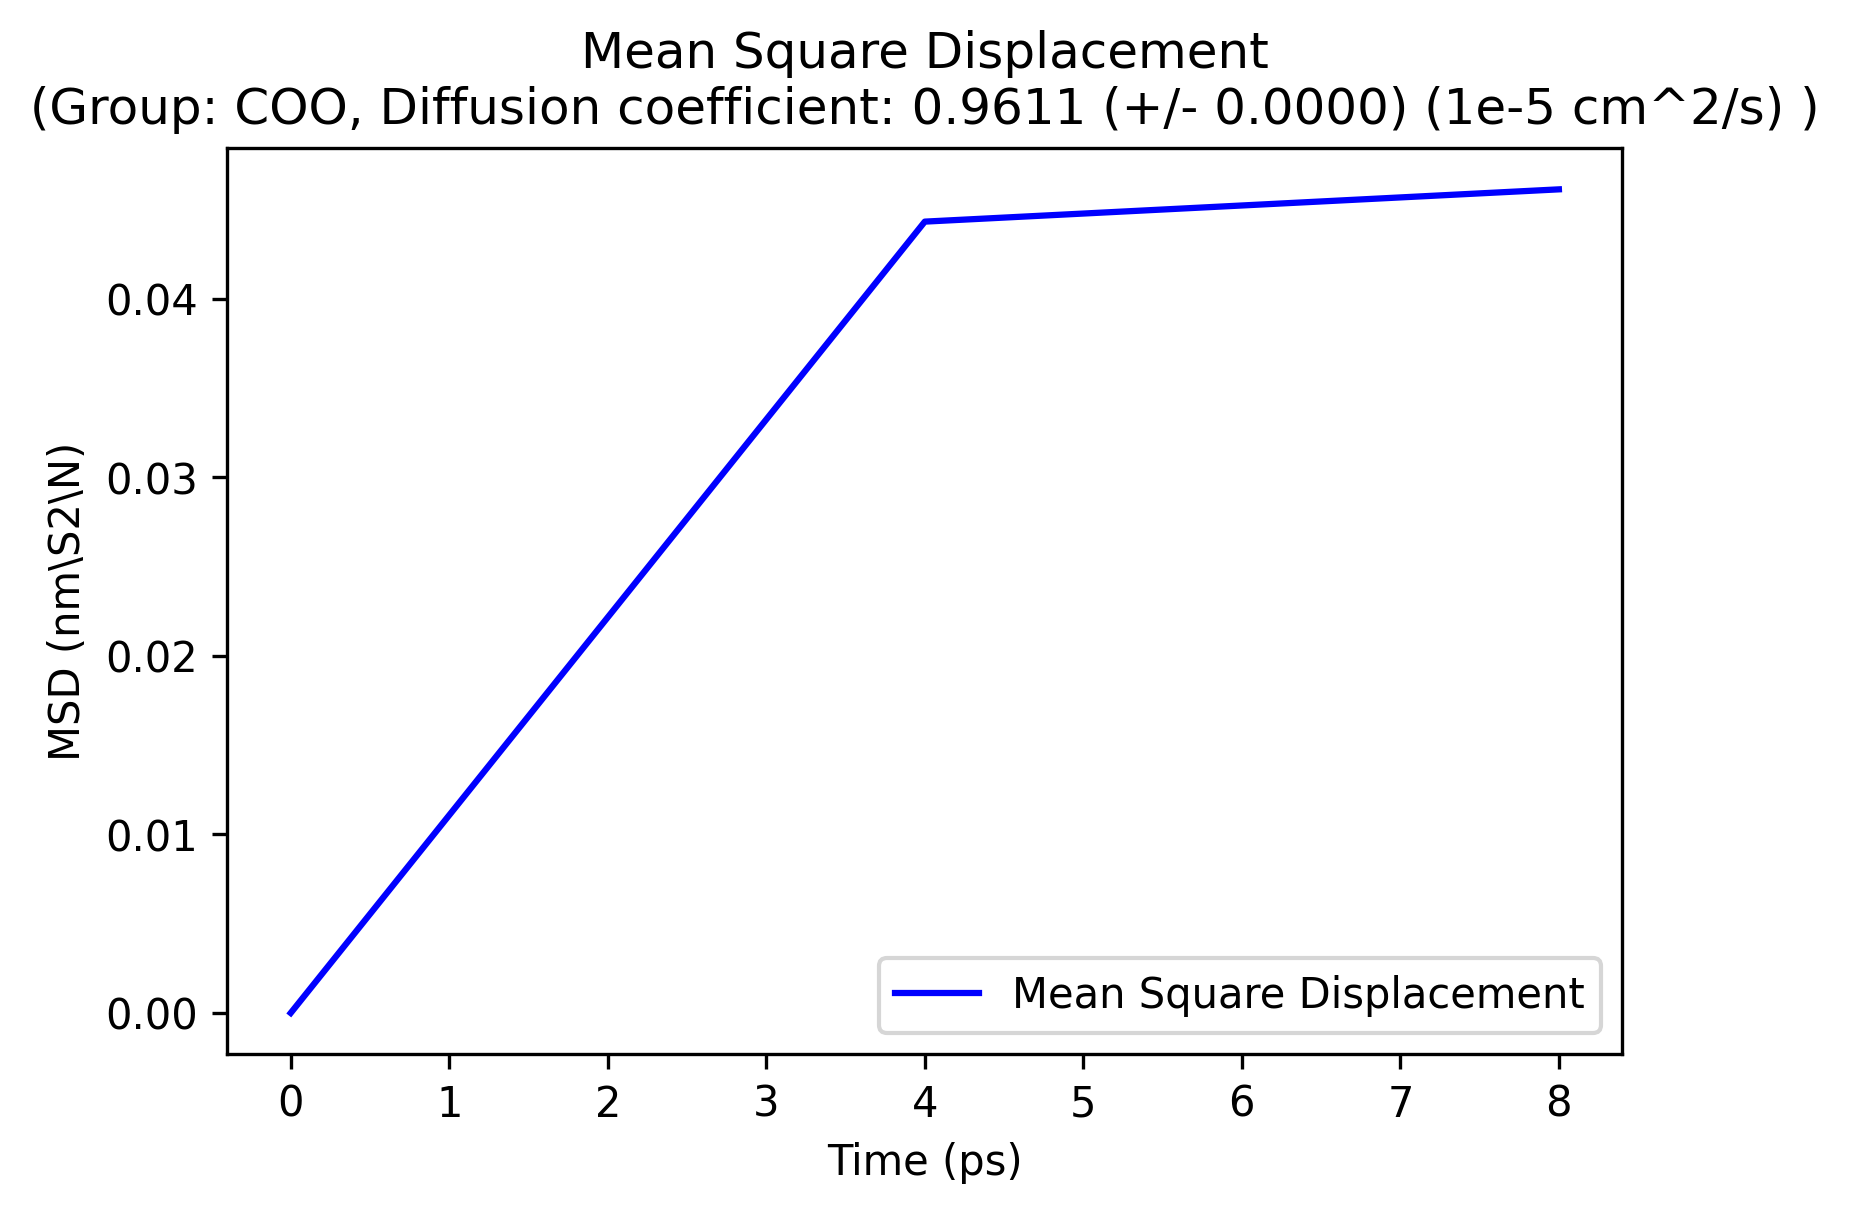

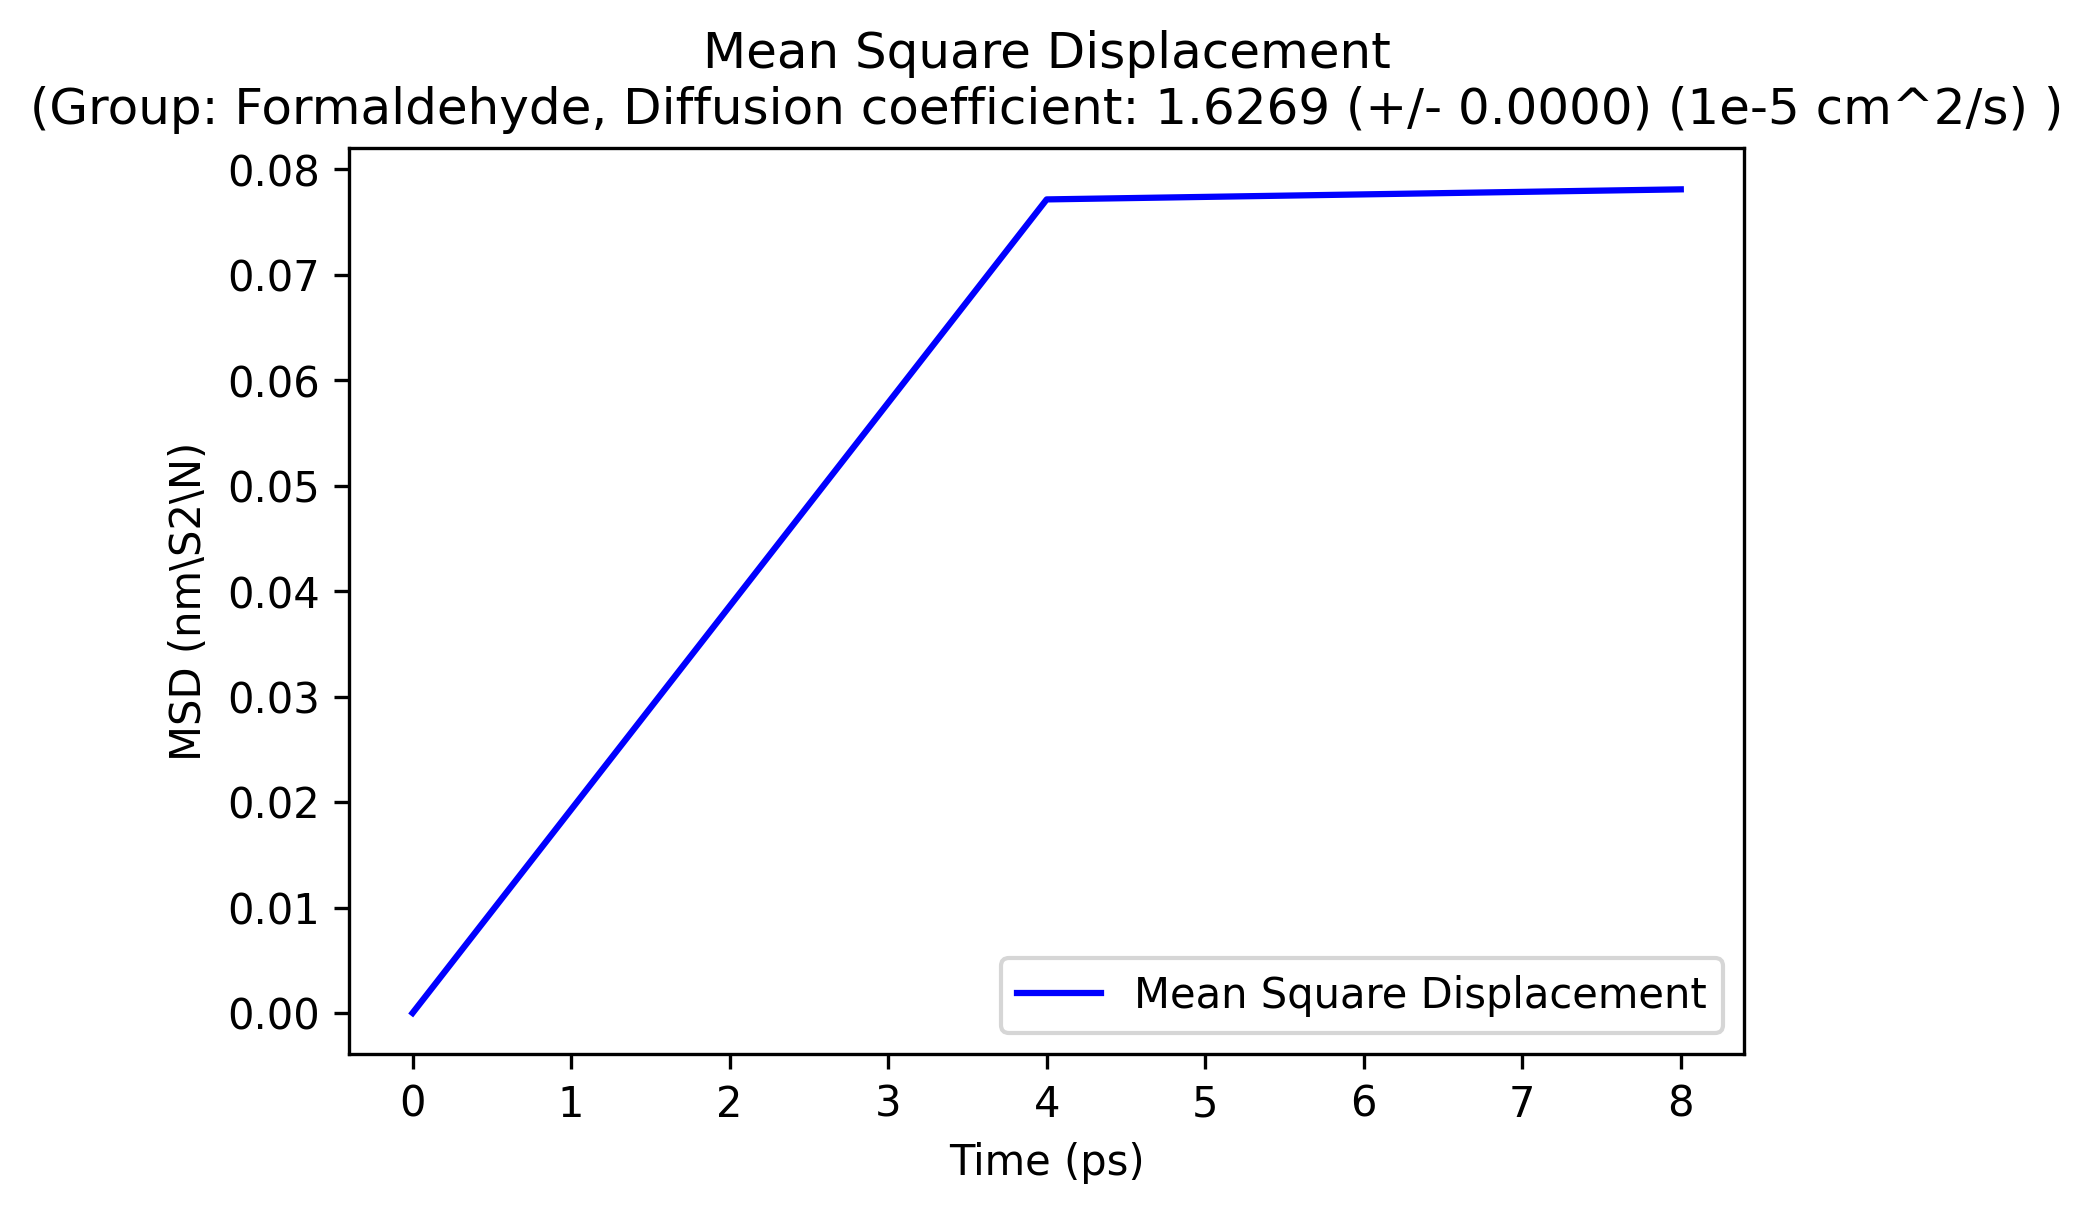

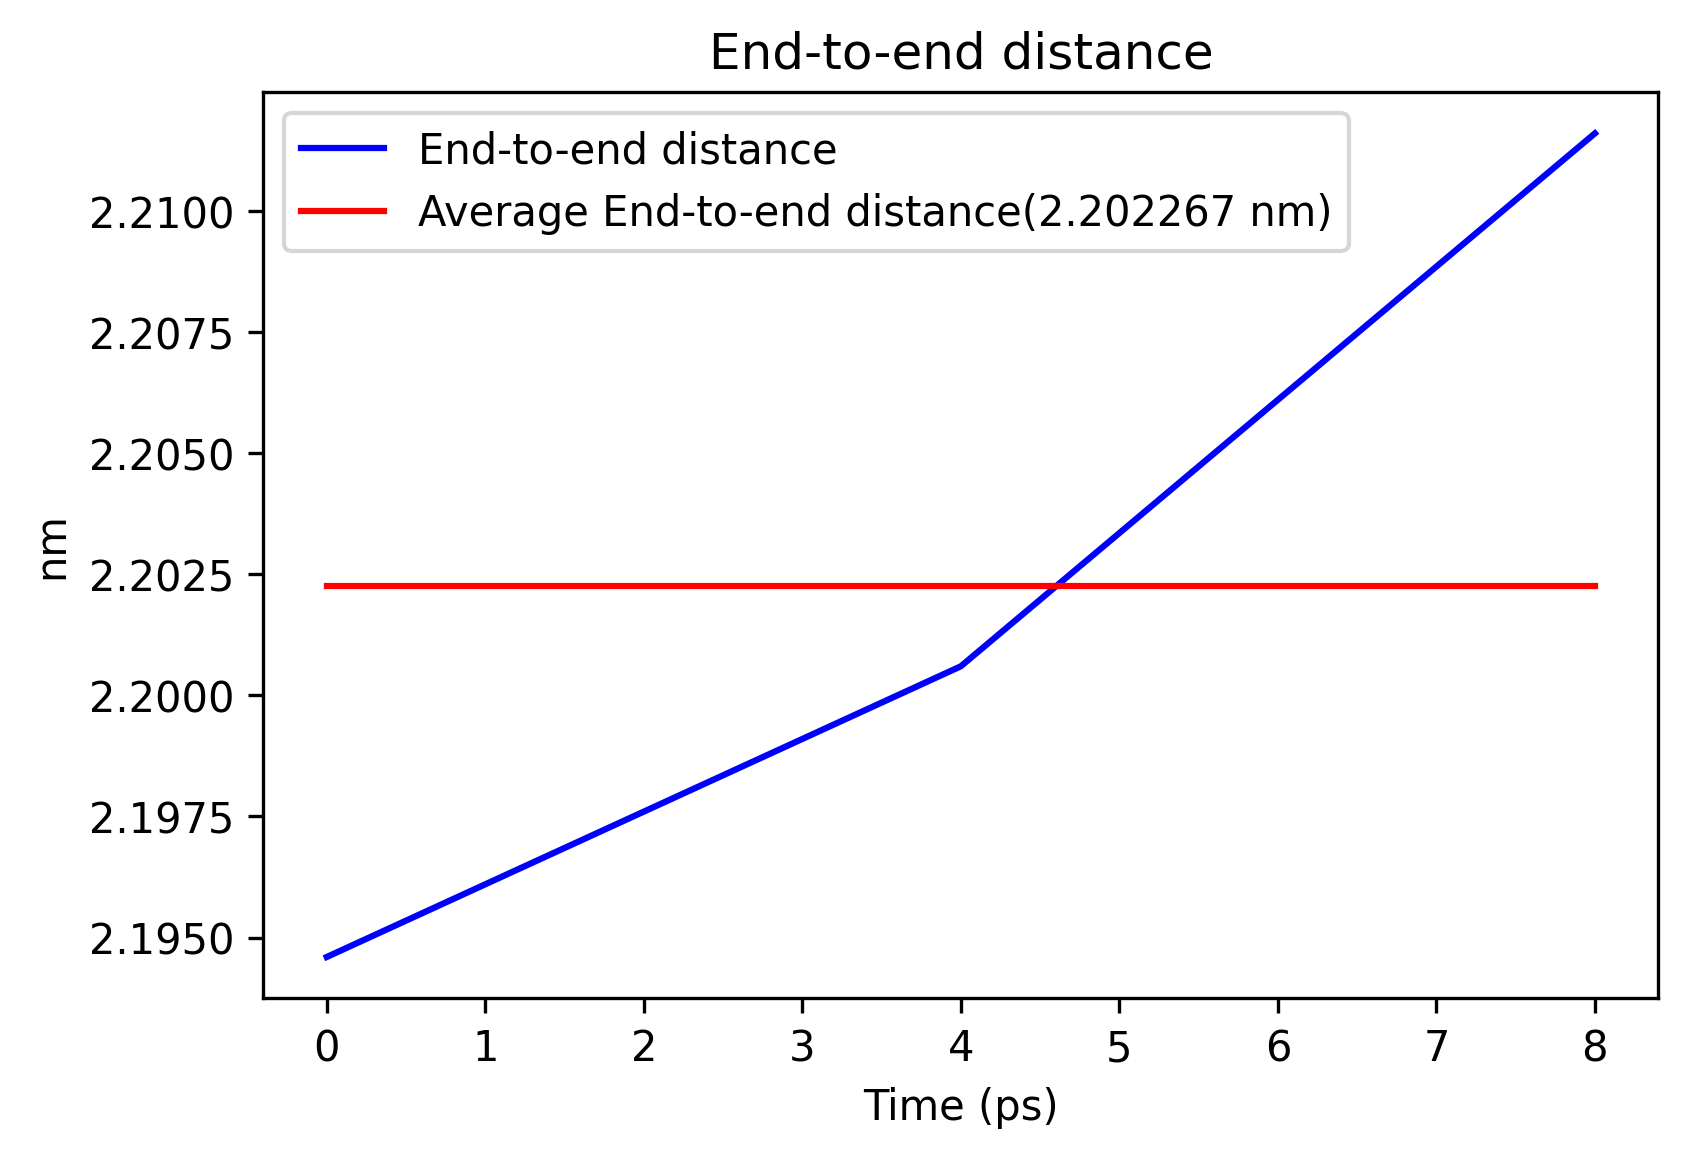

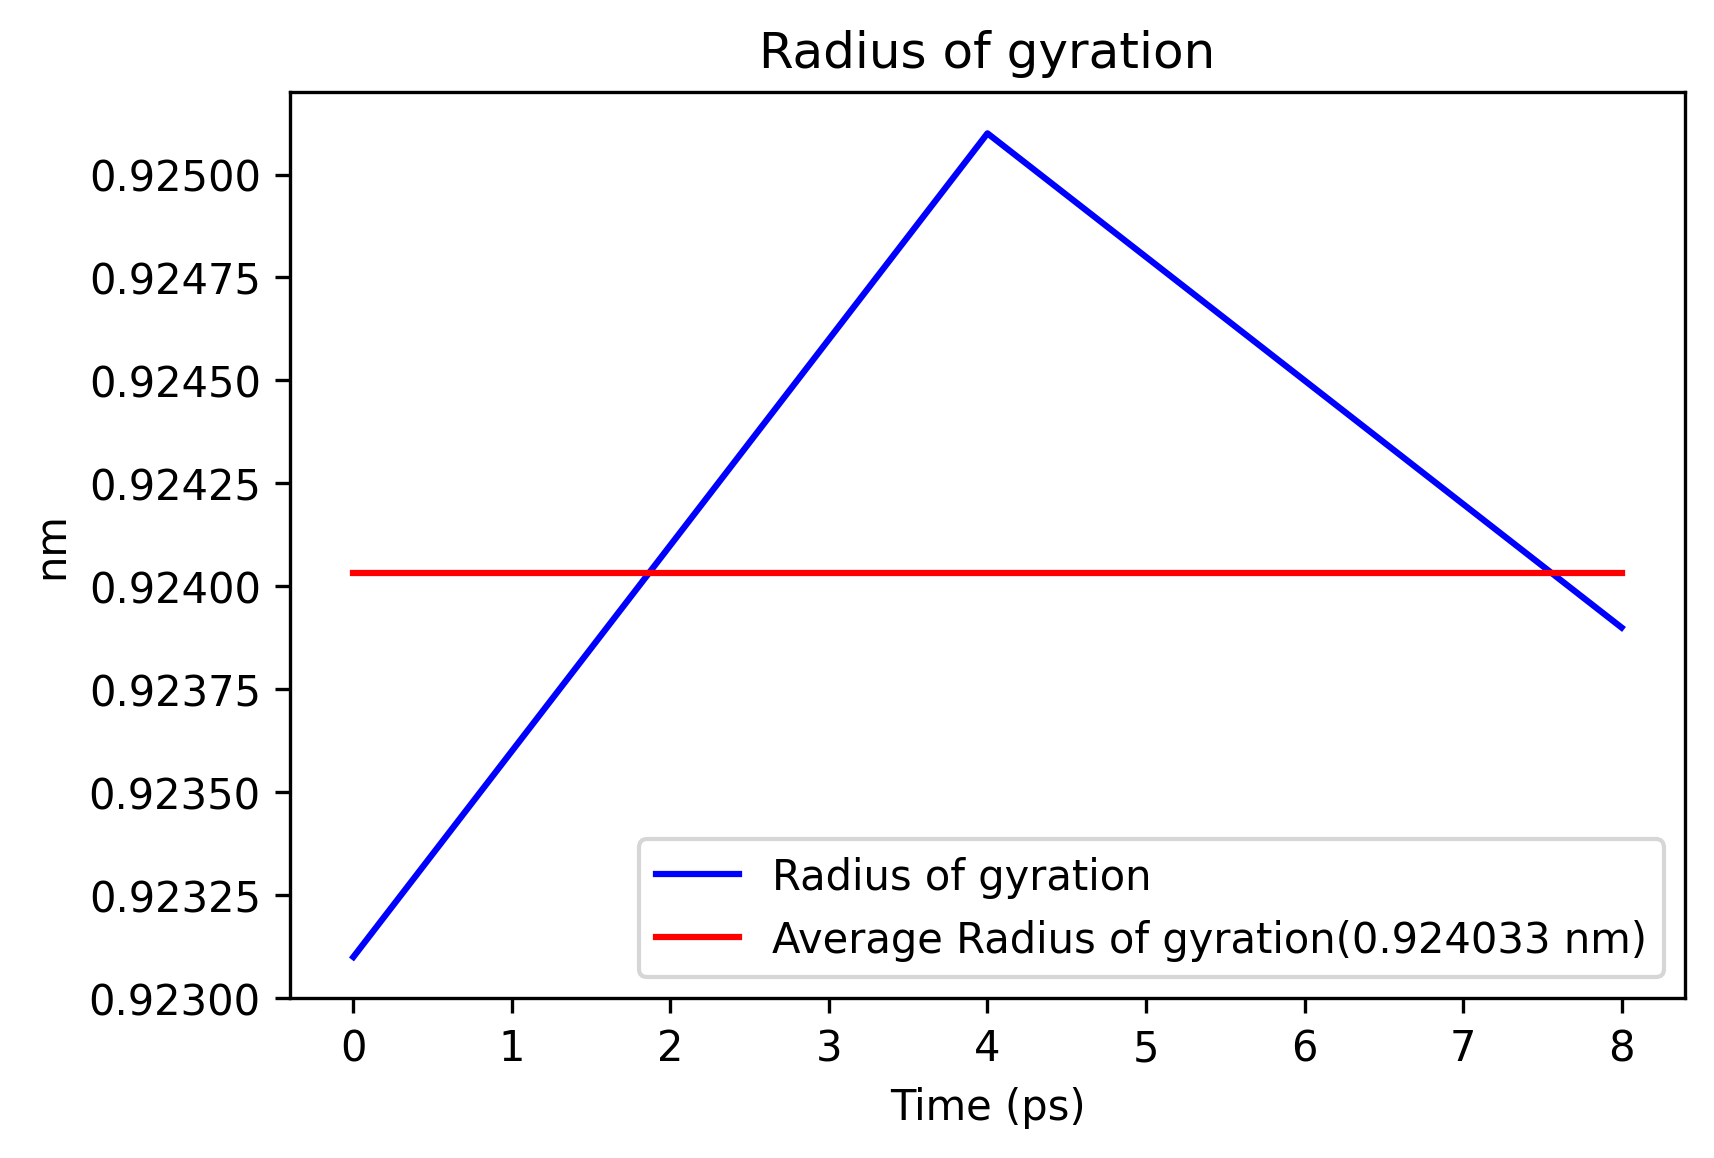

In [10]:
  # path where the gromacs inputs files are stored
SIMULATION_PATH = "/root/symphony/Gromacs_files_2"

# Create container for the wrapper and run the simulation
with SimgromacsSession(
        delete_simulation_files=False,
        simulation_path=SIMULATION_PATH) as session:
    gromacs_wrapper = cuba.Wrapper(session=session)

    # Create simulation entity
    sim = simgromacs.MolecularDynamicsSimulation()

    # Configure the solver parameters for the final run of the simulation (NVT)
    nvt = simgromacs.NVTCalculation()

    thermodynamic_temp = emmo.ThermodynamicTemperature()
    temperature = emmo.Real(hasNumericalData=500)
    thermodynamic_temp.add(temperature, rel=emmo.hasQuantityValue)

    integration_time = simgromacs.IntegrationTime()
    num_steps = emmo.Real(hasNumericalData=5000)
    integration_time.add(num_steps, rel=emmo.hasQuantityValue)

    nvt.add(integration_time, thermodynamic_temp,
            rel=simgromacs.hasOptimizationInput)
    sim.add(nvt, rel=emmo.hasTemporalFirst)

    # Configure the solver parameters for the
    # dimensions optimization step (NPT)
    npt = simgromacs.NPTCalculation()

    thermodynamic_temp = emmo.ThermodynamicTemperature()
    temperature = emmo.Real(hasNumericalData=500)
    thermodynamic_temp.add(temperature, rel=emmo.hasQuantityValue)

    integration_time = simgromacs.IntegrationTime()
    num_steps = emmo.Real(hasNumericalData=5000)
    integration_time.add(num_steps, rel=emmo.hasQuantityValue)

    npt.add(integration_time, thermodynamic_temp,
            rel=simgromacs.hasSimulationInput)

    nvt.add(npt, rel=emmo.hasTemporalNext)

    # Configuration for Post Processing
    energy_computation = simgromacs.EnergyComputation()
    options = emmo.Symbol(hasSymbolData="14, 16, 24")

    # options = emmo.Symbol(hasSymbolData="Total-Energy, Temperature, Density")
    energy_computation.add(options, rel=simgromacs.hasInput)
    npt.add(energy_computation, rel=emmo.hasTemporalNext)

    msd = simgromacs.MeanSquareDistanceComputation()
    options = emmo.Symbol(hasSymbolData="23, 10, 9, 8")
    msd.add(options, rel=simgromacs.hasInput)
    energy_computation.add(msd, rel=emmo.hasTemporalNext)

    pst = simgromacs.PolymerStaticPropertyComputation()
    options = emmo.Symbol(hasSymbolData="23")
    pst.add(options, rel=simgromacs.hasInput)
    msd.add(pst, rel=emmo.hasTemporalNext)

    # Configuration for selecting files from cooling step
    coarse_grain_representation = simgromacs.CoarseGrainRepresentation()
    # add pollutant
    voc = simgromacs.VOC()
    voc.add(coarse_grain_representation, rel=emmo.hasSign)

    # add copolymer input
    copolymer = simgromacs.PMMAconBA()
    copolymer.add(coarse_grain_representation, rel=emmo.hasSign)

    # add pollutant level
    mass_concentration = emmo.MassConcentration()
    pollutant_level = emmo.Real(hasNumericalData=1000)
    mass_concentration.add(pollutant_level, rel=emmo.hasQuantityValue)
    mass_concentration.add(coarse_grain_representation,
                           rel=emmo.hasSpatialPart)

    sim.add(coarse_grain_representation, rel=simgromacs.hasInput)

    sim = gromacs_wrapper.add(sim, rel=emmo.hasPart)

    # run simulation
    gromacs_wrapper.session.run()

The final simulation object will also consists of post processing results added to it. Also, the simulation output directory will contains the output files and simulation graphs.

In [11]:
pretty_print(sim)

- Cuds object:
  uid: 75f16add-830f-46ab-b717-4962c866b60c
  type: simgromacs.MolecularDynamicsSimulation
  superclasses: emmo.EMMO, emmo.Existent, emmo.Holistic, emmo.Item, emmo.Perspective, emmo.Physical, emmo.Process, emmo.Reductionistic, emmo.Simulation, simgromacs.MolecularDynamicsSimulation, simgromacs.SimGromacsWrapper
  description: 
    To Be Determined

   |_Relationship emmo.INVERSE_OF_hasPart:
   | -  cuba.Wrapper cuds object:
   |    uid: a207a1af-5778-4ad2-be3b-e70a5702f71c
   |     |_Relationship emmo.hasPart:
   |       -  simgromacs.MolecularDynamicsSimulation cuds object:
   |          uid: 75f16add-830f-46ab-b717-4962c866b60c
   |          (already printed)
   |_Relationship emmo.hasTemporalFirst:
   | -  simgromacs.NVTCalculation cuds object:
   |    uid: 520e9695-fecb-4c2b-a226-ed9c77d17f81
   |     |_Relationship emmo.INVERSE_OF_hasTemporalFirst:
   |     | -  simgromacs.MolecularDynamicsSimulation cuds object:
   |     |    uid: 75f16add-830f-46ab-b717-4962c866b6